# Exam Solution: VAE for Image Reconstruction and Generation

**Student:** Rimoldi

**Exam Session:** July 15, 2025

This notebook implements the proposed solution for the exam. The goal is to design a deep neural network capable of encoding images into a probabilistic latent space, then reconstructing or generating new images, closely following the structure of the provided example code and the numerical order of the exam sheet.

Notes :
- This notebook takes around 6 minutes to run.
- I underlined the differences between the exam in the following code like this: <font color="red">**CHANGE**</font>.

In [69]:
%pip install tensorflow

import warnings
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops, Model
import matplotlib.pyplot as plt
import seaborn as sns
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
import itertools
import pickle
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

Note: you may need to restart the kernel to use updated packages.


# 0 - Introduction

This section introduces the dataset loading process, utilizing the requests library to download the necessary data from the GitHub repository.

In [70]:
url = "https://raw.githubusercontent.com/PaRi29/DeepLearningExam_VAE/main/assets/input_data.pkl"
print(f"Downloading data from {url}...")
response = requests.get(url)
response.raise_for_status()
with open("input_data.pkl", "wb") as f:
    f.write(response.content)

# 1: MODEL

**Model Choice:** Variational Autoencoder (VAE).


# 2: INPUT AND PREPROCESSING

Normalization: Since we are working with grayscale images, pixel values are normalized from the [0, 255] range to the [0, 1] range by dividing each value by 255.0. This process helps stabilize and speed up model training.

Input Format (Shape): An additional channel dimension is added to the images (since they are grayscale, there is only one channel). The resulting input shape is (batch_size, 28, 28, 1), which is required by convolutional layers.

In [71]:
try:
    with open("input_data.pkl", "rb") as f:
        dd = pickle.load(f)
    print("Data loaded successfully.")
    data = dd['data']
    labels = dd['labels']
except Exception as e:
    print(f"Error loading data: {e}")
    raise

def preprocess_images(images):
    images = images.astype("float32") / 255.0
    images = np.expand_dims(images, axis=-1)
    return images

data = preprocess_images(data)

# Create train, validation, and test splits
test_fraction = 0.1
val_fraction = 0.2

num_samples = data.shape[0]
num_test = int(num_samples * test_fraction)
num_val = int(num_samples * val_fraction)
num_train = num_samples - num_val - num_test

# Shuffle the data before splitting
indices = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_test = data[:num_test]
y_test = labels[:num_test]

x_val = data[num_test:num_test+num_val]
y_val = labels[num_test:num_test+num_val]

x_train = data[num_test+num_val:]
y_train = labels[num_test+num_val:]

INPUT_SHAPE = x_train.shape[1:]

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Data loaded successfully.
Training data shape: (4900, 28, 28, 1)
Validation data shape: (1400, 28, 28, 1)
Test data shape: (700, 28, 28, 1)


# 3: MODEL CONFIGURATION

### a. Model Composition
The VAE consists of an Encoder, a Decoder, and a specialized `Sampling` layer. 
**Conceptual Outline:** `Input Image` -> **[Encoder]** -> `Latent Distribution` -> **[Sampling]** -> `Latent Vector` -> **[Decoder]** -> `Reconstructed Image`

### b. Image Projection (Encoder)
The Encoder is a CNN that maps an image to a probabilistic latent space. It reduces the image's dimensionality through convolutional and pooling layers, finally outputting the mean (`z_mean`) and log-variance (`z_log_var`) of the learned distribution.

### c. Image Reconstruction (Decoder)
The Decoder is a deconvolutional network, symmetric to the encoder. It takes a latent vector `z` (sampled from the distribution defined by `z_mean` and `z_log_var`), upsamples it through transposed convolutions (or upsampling layers), and reconstructs the image.

### d. Generation of New Images
To generate new images, we discard the encoder and use only the trained decoder. A random vector `z` is sampled from a standard normal distribution N(0,1) and passed to the decoder, which then generates a new, coherent image that was not in the original dataset.

### e. Hyperparameters
Key hyperparameters to tune include `learning_rate`, `batch_size`, `latent_dim` (the size of the latent space), and `kl_reg` (the weight of the KL divergence loss). A random search is performed to find a good combination of these values.

In [72]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z (reparameterization trick)."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

def vae_enc(input_shape, latent_dim, filter_base=32, dense_units=16):
    """Encoder model (Projection), configurable via hyperparameters."""
    encoder_inputs = keras.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(filter_base, 3, activation="relu", padding="same")(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, padding="same")(x)  # 28x28 -> 14x14
    
    # Block 2
    x = layers.Conv2D(filter_base * 2, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, padding="same")(x)  # 14x14 -> 7x7
    
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def vae_dec(latent_dim, filter_base=32, dense_units=16):
    """Decoder model (Reconstruction), configurable via hyperparameters."""
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # Initial part to prepare for reconstruction
    x = layers.Dense(7 * 7 * (filter_base * 2), activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, filter_base * 2))(x)
    
    # Block 1
    x = layers.UpSampling2D(2)(x)  # 7x7 -> 14x14
    x = layers.Conv2D(filter_base * 2, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Block 2
    x = layers.UpSampling2D(2)(x)  # 14x14 -> 28x28
    x = layers.Conv2D(filter_base, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


In [73]:
# Define the parameter grid and search function for hyperparameters (Point 3e)
param_grid = {
    'learning_rate': [1e-4, 1e-3],
    'batch_size':    [64, 128],
    'latent_dim':    [2, 8],
    'kl_reg':        [0.5, 1.0, 2.0],
    'optimizer':     ['adam', 'rmsprop'],
    'filter_base':   [16, 32],
    'dense_units':   [16, 32],
    'patience':      [2, 3, 5],
    'min_delta':     [0.0, 1e-4, 1e-3],
    'restore_best_weights': [True, False],
    'monitor':       ['val_loss', 'val_reconstruction_loss']
}
num_samples = 5 # Number of random combinations to test


def random_search_vae(VAE_MODEL, INPUT_SHAPE, param_grid, x_train, x_val, samples=num_samples):
    """
    Performs a random search over the defined parameter grid.
    
    Args:
        VAE_MODEL: The VAE model class (which must be defined).
        INPUT_SHAPE: The shape of the input images.
        param_grid: A dictionary of hyperparameters to search over.
        x_train: Training data.
        x_val: Validation data.
        samples: The number of random combinations to try.
    
    Returns:
        The dictionary containing the best hyperparameter configuration found.
    """
    combos = list(itertools.product(*param_grid.values()))
    sampled_combos = random.sample(combos, min(samples, len(combos)))
    configs = [dict(zip(param_grid.keys(), c)) for c in sampled_combos]
    best_val_loss = np.inf
    best_cfg = None

    for idx, cfg in enumerate(configs):
        print(f"\n=== Training config {idx+1}/{len(configs)} ===")
        print("Config:", cfg)
        
        # Build model with current config
        encoder = vae_enc(INPUT_SHAPE, cfg['latent_dim'], cfg['filter_base'], cfg['dense_units'])
        decoder = vae_dec(cfg['latent_dim'], cfg['filter_base'], cfg['dense_units'])
        vae_model = VAE_MODEL(encoder, decoder, reg=cfg['kl_reg'])
        
        # Select and configure optimizer
        if cfg['optimizer'] == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=cfg['learning_rate'])
        else: # rmsprop
            optimizer = keras.optimizers.RMSprop(learning_rate=cfg['learning_rate'])
            
        vae_model.compile(optimizer=optimizer)
        
        # Define Early Stopping callback with all relevant hyperparameters
        early_stopping = keras.callbacks.EarlyStopping(
            monitor=cfg['monitor'],
            patience=cfg['patience'],
            min_delta=cfg['min_delta'],
            verbose=1,
            restore_best_weights=cfg['restore_best_weights'],
            mode='min'
        )

        # Train the model
        history = vae_model.fit(
            x_train, x_train,
            epochs=50, # Set a high number; Early Stopping will terminate training
            batch_size=cfg['batch_size'],
            validation_data=(x_val, x_val),
            callbacks=[early_stopping],
            verbose=1 # Suppress epoch-by-epoch output for cleaner search
        )
        
        # Get the best validation loss from this run (thanks to restore_best_weights)
        # Use the same metric as monitored
        monitor_metric = cfg['monitor']
        if monitor_metric in history.history:
            final_val_loss = min(history.history[monitor_metric])
        else:
            # fallback to val_loss if custom metric not found
            final_val_loss = min(history.history['val_loss'])
        print(f"Best {monitor_metric} for this config: {final_val_loss:.4f}")
        
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_cfg = cfg
            print(f"*** New best model found! ***")

    print("\n=== Best Results Summary ===")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print("Best configuration:", best_cfg)
    return best_cfg


# 4: OUTPUT

The output layer of the decoder is a `Conv2D` layer designed as follows:
- **Filters:** `1`. This is because the output images are grayscale and have only one channel.
- **Activation Function:** `sigmoid`. The input images were normalized to the range [0, 1]. The sigmoid function outputs values in this same [0, 1] range, making it the natural choice for the final layer. This ensures the reconstructed pixel values are on the same scale as the input, which is essential for calculating the reconstruction loss.

### 5. LOSS

CHANGE with respect to exam: In the exam, I **mistakenly used Mean Absolute Error (MAE)** as the reconstruction loss.  
While MAE is sometimes used in **standard autoencoders** due to its robustness to outliers, it is **not the canonical choice for Variational Autoencoders (VAEs)**.

The loss function for a **VAE** consists of two main components, which reflect its **probabilistic generative nature**:

---

**1. Reconstruction Loss**  
For VAEs, the reconstruction term is derived from the assumption that pixels are generated from a Gaussian distribution. Under this assumption, the appropriate reconstruction loss is the **Mean Squared Error (MSE)**:

$$
\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2
$$

Where:
- $x_i$ is the original pixel value,
- $\hat{x}_i$ is the reconstructed pixel value,
- $N$ is the total number of pixels.


**2. Kullback-Leibler (KL) Divergence**  
This term ensures that the latent space distribution learned by the encoder remains close to a prior distribution (usually a standard normal $\mathcal{N}(0, I)$):

$$
\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left(1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
$$

Where:
- $\mu_j$ and $\sigma_j$ are the predicted mean and standard deviation for latent dimension $j$,
- $d$ is the dimensionality of the latent space.

This term is **crucial** for enabling the model to generalize and generate new data by sampling from the latent space.

---

**3. Total Loss Function**

The final VAE loss combines the two components:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

Where:
- $\beta$ is a hyperparameter that balances reconstruction accuracy with latent space regularization.  
  In the standard VAE, $\beta = 1$, but it can be tuned (e.g., in $\beta$-VAEs) to control disentanglement.

---

**Summary**  
My initial response mistakenly applied a loss formulation more suited to standard autoencoders.  
A correct VAE implementation must:
- Use **MSE** for reconstruction (derived from Gaussian likelihood),
- Include the **KL divergence** for latent regularization,
- Combine both in a total loss that supports both reconstruction and generative capabilities.

This correction reflects a deeper understanding of **why** these loss terms are used in VAEs and how they relate to the model’s probabilistic foundations.

In [74]:
class VAE(Model):
    def __init__(self, encoder, decoder, reg=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reg = reg
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    @tf.function
    def train_step(self, data):
        # Unpack the data tuple. 'x' will be your input tensor.
        # In this VAE case, both elements of the tuple are the same,
        # so we can assign the first to 'x' and ignore the second.
        x, _ = data

        with tf.GradientTape() as tape:
            # Pass the single input tensor 'x' to the encoder
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            
            # Also, ensure you use 'x' to calculate the reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=(1, 2, 3))
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = reconstruction_loss + self.reg * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        } 
       
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        # Calculate reconstruction loss directly
        reconstruction_loss = ops.mean(
            ops.sum(ops.square(data - reconstruction), axis=(1, 2))
        )
        
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + self.reg * kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)


# 6: MODEL EVALUATION

The model is evaluated through a comprehensive process that includes hyperparameter tuning, final training, and both quantitative and qualitative assessment.


### Hyperparameter Search Execution
First, we execute the random search defined in Point 3e to find the best hyperparameters using a validation set.

In [75]:
best_config = random_search_vae(
    VAE_MODEL=VAE,
    INPUT_SHAPE=INPUT_SHAPE,
    param_grid=param_grid,
    x_train=x_train,
    x_val=x_val
)


=== Training config 1/5 ===
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'latent_dim': 2, 'kl_reg': 0.5, 'optimizer': 'rmsprop', 'filter_base': 16, 'dense_units': 32, 'patience': 2, 'min_delta': 0.001, 'restore_best_weights': True, 'monitor': 'val_loss'}
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - kl_loss: 0.0716 - loss: 129.2583 - reconstruction_loss: 129.2225 - val_kl_loss: 1.1114 - val_loss: 115.0126 - val_reconstruction_loss: 114.4569
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - kl_loss: 1.5502 - loss: 110.7568 - reconstruction_loss: 109.9817 - val_kl_loss: 2.7256 - val_loss: 100.2619 - val_reconstruction_loss: 98.8991
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - kl_loss: 3.0823 - loss: 95.7532 - reconstruction_loss: 94.2121 - val_kl_loss: 4.7259 - val_loss: 85.4664 - val_reconstruction_loss: 83.1035
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - kl_loss: 4.9986 - loss: 81.3759 - reconstruction_loss: 78.8767 - val_kl_loss: 5.0468 - val_loss: 

### Final Model Training

Using the best hyperparameters found, we instantiate and train a final model on the entire training dataset for a larger number of epochs.

In [76]:
# Imposta i migliori iperparametri trovati o usa i default se la ricerca non ha avuto successo
if best_config is None:
    print("Random search fallita o saltata. Uso valori di default.")
    best_config = {
        'learning_rate': 1e-3,
        'batch_size': 128,
        'latent_dim': 2,
        'kl_reg': 1.0,
        'filter_base': 16,
        'dense_units': 16,
        'optimizer': 'adam',
        'patience': 3,
        'min_delta': 1e-4,
        'restore_best_weights': True,
        'monitor': 'val_loss'
    }

LATENT_DIM = best_config.get('latent_dim', 2)
BATCH_SIZE = best_config.get('batch_size', 128)
LEARNING_RATE = best_config.get('learning_rate', 1e-3)
KL_REG = best_config.get('kl_reg', 1.0)
FILTER_BASE = best_config.get('filter_base', 16)
DENSE_UNITS = best_config.get('dense_units', 16)
OPTIMIZER = best_config.get('optimizer', 'adam')
EPOCHS = 20

print("\n--- Training Final Model with Best Hyperparameters ---")
print(f"Config: {best_config}")

# Ricrea il dataset completo unendo train e validation
import numpy as np
x_train_full = np.concatenate([x_train, x_val], axis=0)

# Crea encoder e decoder con la struttura aggiornata
final_encoder = vae_enc(INPUT_SHAPE, LATENT_DIM, filter_base=FILTER_BASE, dense_units=DENSE_UNITS)
final_decoder = vae_dec(LATENT_DIM, filter_base=FILTER_BASE, dense_units=DENSE_UNITS)
final_vae = VAE(final_encoder, final_decoder, reg=KL_REG)

if OPTIMIZER == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
elif OPTIMIZER == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
else:
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

final_vae.compile(optimizer=optimizer)

final_encoder.summary()
final_decoder.summary()

# EarlyStopping callback se richiesto
callbacks = []
if 'patience' in best_config and 'monitor' in best_config:
    callbacks.append(
        keras.callbacks.EarlyStopping(
            monitor=best_config['monitor'],
            patience=best_config['patience'],
            min_delta=best_config['min_delta'],
            verbose=1,
            restore_best_weights=best_config['restore_best_weights'],
            mode='min'
        )
    )

history = final_vae.fit(
    x_train_full, x_train_full,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    callbacks=callbacks
)


--- Training Final Model with Best Hyperparameters ---
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'latent_dim': 8, 'kl_reg': 0.5, 'optimizer': 'rmsprop', 'filter_base': 16, 'dense_units': 16, 'patience': 3, 'min_delta': 0.001, 'restore_best_weights': False, 'monitor': 'val_reconstruction_loss'}


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 28, 28,    │        160 │ input_layer_42[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_105[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 14, 14,    │      4,640 │ max_pooling2d_42… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_106[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 7, 7, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 1568)      │          0 │ max_pooling2d_43… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 16)        │     25,104 │ flatten_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │        136 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │        136 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_21         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,368 (118.62 KB)

 Trainable params: 30,272 (118.25 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1568)           │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_42 (UpSampling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_43 (UpSampling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,321 (110.63 KB)

 Trainable params: 28,225 (110.25 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - kl_loss: 0.1273 - loss: 125.2077 - reconstruction_loss: 125.1440 - val_kl_loss: 1.0921 - val_loss: 105.8814 - val_reconstruction_loss: 105.3353
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - kl_loss: 1.1629 - loss: 103.2452 - reconstruction_loss: 102.6637 - val_kl_loss: 2.4802 - val_loss: 93.2205 - val_reconstruction_loss: 91.9804
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - kl_loss: 3.6271 - loss: 89.1877 - reconstruction_loss: 87.3741 - val_kl_loss: 6.1845 - val_loss: 76.6302 - val_reconstruction_loss: 73.5380
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - kl_loss: 7.0449 - loss: 72.6679 - reconstruction_loss: 69.1455 - val_kl_loss: 8.0260 - val_loss: 63.3882 - val_reconstruction_loss: 59.3752
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - kl_loss: 8.5778 - loss: 60.6579 - reconstruction_loss: 56.3690 - val_kl_loss: 8.5705 - val_loss: 55.4299 - val_reconstruction_loss: 51.1447
Epoch 6/20
50/50 ━━━━━━━━━━━━

### Final Model Assessment
The reconstruction capabilities are evaluated both quantitatively and qualitatively.

1.  **Quantitative Evaluation:** We use the trained model to reconstruct the test set images and calculate the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** between the original and reconstructed images. Lower values indicate better performance.
2.  **Qualitative Evaluation:** We visually inspect the results by plotting original test images against their reconstructions. This helps assess the fidelity and sharpness of the output. We also visualize the generative latent space (if 2D) to confirm that the model has learned a smooth manifold for generating new, coherent images.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Test Set Evaluation:
Mean Squared Error (MSE): 0.0310

--- Qualitative Evaluation ---


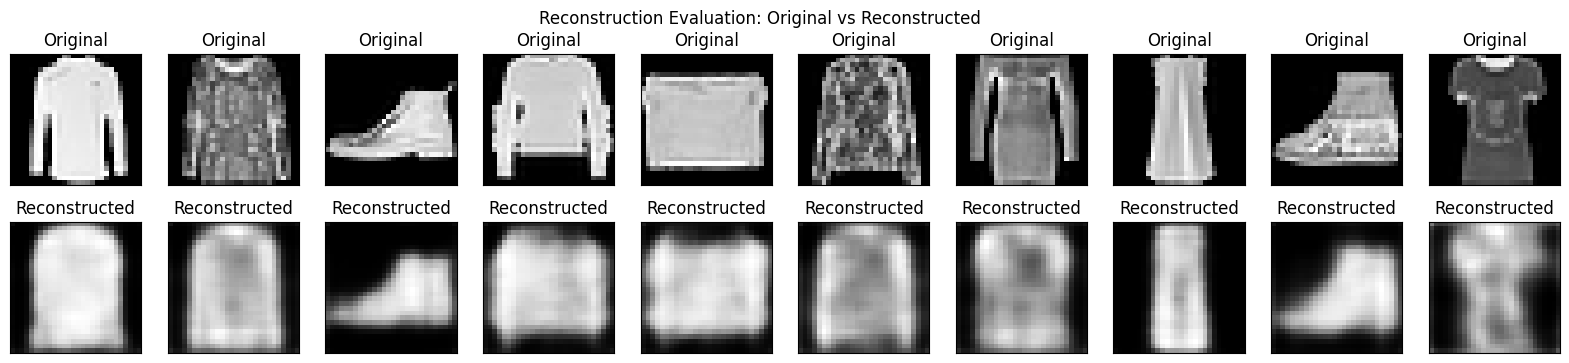

In [77]:
# Quantitative Evaluation of Reconstruction
reconstructed_images = final_vae.predict(x_test)
test_mse = mean_squared_error(x_test.flatten(), reconstructed_images.flatten())

print(f"\nTest Set Evaluation:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")

# Qualitative Evaluation
def plot_reconstructions(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    plt.suptitle("Reconstruction Evaluation: Original vs Reconstructed")
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.set_title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.set_title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_latent_space(vae, n=15, figsize=15):
    digit_size = 28
    scale = 1.5
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit
    plt.figure(figsize=(figsize, figsize))
    plt.title("Generative Latent Space Exploration")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

print("\n--- Qualitative Evaluation ---")
plot_reconstructions(x_test, reconstructed_images)

# The latent space plot is only meaningful for 2D latent spaces
if LATENT_DIM == 2:
    print("\n--- Latent Space Visualization (for LATENT_DIM=2) ---")
    plot_latent_space(final_vae)
